# UTILS

In [23]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import os
import PIL
from PIL import Image
import pathlib
import pickle

import matplotlib.pyplot as plt

from scipy.stats import uniform, randint
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV

# Load Data & Models

In [24]:
df = pd.read_csv("data/data_pp.csv", index_col=0)

df.head(2)

,Name,Genre,Price,Description,Updated,Size,RequiresAndroid,ContentRating,OfferedBy,InteractiveElements,InAppProductsMin,InAppProductsMax,InAppProductsBinary,Target,NumOfWord,AvgNumOfChars,DigitalPurchases,InAppPurchases,InGamePurchases,SharesInfo,SharesLocation,UsersInteract,LastUpdate,LastUpdateLn,InAppProductsMean,FreeOrNot,PriceSegment,SizeLn2,Rmean,Gmean,Bmean,Rstd,Gstd,Bstd
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,Arcade,0.0,Jump and fly your way through danger in this r...,2019-12-11,58.0,4.0,1,RobTop Games,['No Element'],0.00,0.00,0,35.2,3.0,5.333333,0,0,0,0,0,0,900,6.802395,0.0,1.0,0.0,5.857981,109.975656,123.210478,55.596528,117.723707,78.084704,73.268847
1,Fastlane: Road to Revenge,Action,0.0,THEY TOOK YOUR CITY. THEY SHOULD’VE TAKEN YOUR...,2021-08-16,92.0,4.4,2,Space Ape,['Digital Purchases'],0.99,99.99,1,32.2,4.0,5.250000,1,0,0,0,0,0,286,5.655992,49.5,1.0,0.0,6.523562,111.865795,123.851474,104.913302,78.302310,87.087182,76.248771


In [25]:
# load splitted indexes
with open('data/split_dict.pkl', 'rb') as f:
    split_dict = pickle.load(f)

In [26]:
from tensorflow.keras.models import load_model

In [27]:
# Load the model
model = load_model('models/nlp_model.h5') 

In [28]:
# load model dictionary
with open('models/model_dict.pkl', 'rb') as dict_handle:
    model_dict = pickle.load(dict_handle)

# MODELS

In [29]:
df.head(1)

,Name,Genre,Price,Description,Updated,Size,RequiresAndroid,ContentRating,OfferedBy,InteractiveElements,InAppProductsMin,InAppProductsMax,InAppProductsBinary,Target,NumOfWord,AvgNumOfChars,DigitalPurchases,InAppPurchases,InGamePurchases,SharesInfo,SharesLocation,UsersInteract,LastUpdate,LastUpdateLn,InAppProductsMean,FreeOrNot,PriceSegment,SizeLn2,Rmean,Gmean,Bmean,Rstd,Gstd,Bstd
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,Arcade,0.0,Jump and fly your way through danger in this r...,2019-12-11,58.0,4.0,1,RobTop Games,['No Element'],0.0,0.0,0,35.2,3.0,5.333333,0,0,0,0,0,0,900,6.802395,0.0,1.0,0.0,5.857981,109.975656,123.210478,55.596528,117.723707,78.084704,73.268847


## Preparation

In [31]:
tb_cols = ["Genre","Price","Size","RequiresAndroid",
            "ContentRating","OfferedBy","InAppProductsMin",
            "InAppProductsMax","InAppProductsMean","InAppProductsBinary",
            "NumOfWord","AvgNumOfChars",
            "DigitalPurchases","InAppPurchases","InGamePurchases",
            "SharesInfo","SharesLocation","UsersInteract",
            "LastUpdate","LastUpdateLn","FreeOrNot","PriceSegment","SizeLn2",
            # "R_mean","G_mean","B_mean",
            # "R_std","G_std","B_std",
            "Target",
            ]

In [207]:
class FinalModels:

        BASEDIR = os.getcwd()+"\\data\\icon_png\\"

        def __init__(self, df):
                self.train_ids = None
                self.test_ids = None

                self.train_ids_path = None
                self.test_ids_path = None

                self.train_imgs = None
                self.test_imgs = None

                self.df = df

        # tabular columns
        tb_cols = ["Genre","Price","Size","RequiresAndroid",
            "ContentRating","OfferedBy","InAppProductsMin",
            "InAppProductsMax","InAppProductsMean","InAppProductsBinary",
            "NumOfWord","AvgNumOfChars",
            "DigitalPurchases","InAppPurchases","InGamePurchases",
            "SharesInfo","SharesLocation","UsersInteract",
            "LastUpdate","LastUpdateLn","FreeOrNot","PriceSegment","SizeLn2",
            # "R_mean","G_mean","B_mean",
            # "R_std","G_std","B_std",
            "Target",
            ]
        
        target_name= "Target"

        def get_data(self, cols:list):
                Xy_train = self.df.loc[self.train_ids, cols]
                Xy_test = self.df.loc[self.test_ids, cols]

                X_train = Xy_train.drop(columns=[self.target_name])
                X_test = Xy_test.drop(columns=[self.target_name])

                y_train = Xy_train[[self.target_name]]
                y_test = Xy_test[[self.target_name]]

                if "Genre" in cols:
                        X_train = pd.get_dummies(X_train, columns=["Genre"], drop_first=True)
                        X_test = pd.get_dummies(X_test, columns=["Genre"], drop_first=True)

                return X_train, X_test, y_train, y_test
        

        def train_test_split(self, test_size=0.25, random_seed=42, return_ids=False):
                if self.df.index.nunique()==self.df.shape[0]:
                        ids = df.index.to_numpy()
                        np.random.seed(random_seed)
                        test_ids = np.random.choice(ids, int(len(ids)*test_size))
                        train_ids = np.array(list(set(ids)-set(test_ids)))
                        self.train_ids = train_ids
                        self.test_ids = test_ids
                        print("Successfuly splitted the data!")

                        self.train_ids_path = [self.BASEDIR+str(i)+".png" for i in train_ids]
                        self.test_ids_path = [self.BASEDIR+str(i)+".png" for i in test_ids]
                        self.append_images()
                        
                        print("Successfuly splitted the images!")
                        if return_ids:
                                return train_ids, test_ids
                
        def append_images(self):
                reduced_size = (28,28)
                train_imgs = []
                for img_path in self.train_ids_path:
                        img = Image.open(img_path)
                        img = img.resize(reduced_size)
                        train_imgs.append(np.array(img))
                self.train_imgs = np.array(train_imgs)

                test_imgs = []
                for img_path in self.test_ids_path:
                        img = Image.open(img_path)
                        img = img.resize(reduced_size)
                        test_imgs.append(np.array(img))
                self.test_imgs = np.array(test_imgs)
                
        def show_img(self, img_id:int, plot=True, return_info=False, print_info=False):

                img_path = self.BASEDIR+str(img_id)+".png"
                img = Image.open(img_path)


                if plot:
                        fig = plt.figure()
                        plt.title(f'ID: {img_id}, Name: {self.df.loc[int(img_id), "Name"]}')
                        plt.imshow(img)
                
                info_dict = {
                        # "Filename": img.filename,
                        "Image Size": img.size,
                        # "Image Height": img.height,
                        # "Image Width": img.width,
                        # "Image Format": img.format,
                        "Image Mode": img.mode,
                        # "Image is Animated": getattr(img, "is_animated", False),
                        # "Frames in Image": getattr(img, "n_frames", 1)
                        }
                if print_info:
                        for label,value in info_dict.items():
                                print(f"{label:25}: {value}")
                if return_info:
                        return info_dict

        # def plot_batch(self, img_ids=[], c=None):

        #         if random_num != None:
        #                 img_ids = np.choice(self.df.index, 15)
                
        #         plt.figure(figsize=(16,8))
        #         for i in range(5):
        #                 plt.subplot(2,5,i+1)
        #                 fname = str(i)+".jpg"
        #                 image = plt.imread(new_base_dir / "train" / "Cat"/ fname)
        #                 plt.imshow(image)
        #                 plt.axis("off")
        #                 plt.subplot(2,5,i+1+5)
        #                 image = plt.imread(new_base_dir / "train" / "Dog"/fname)
        #                 plt.imshow(image)
        #                 plt.axis("off")
                
        # def 
        

        # df_bm = pd.get_dummies(df_bm, columns=["Genre"])
        # df_ffnn = pd.get_dummies(df_ffnn, columns=["Genre"])

### Demonstrating the class

In [208]:
Data = FinalModels(df)

In [209]:
# check if all the images (360, 360)
for i in Data.df.index:
    if Data.show_img(i, plot=False, return_info=True)['Image Size']!=(360,360):
        print("not 360,360 at {i}")
        break

In [210]:
Data.train_test_split(test_size=0.25, random_seed=42, return_ids=False)

Successfuly splitted the data!
Successfuly splitted the images!


In [211]:
print(Data.train_ids.shape, Data.train_imgs.shape)
print(Data.test_ids.shape, Data.test_imgs.shape)

(1858,) (1858, 28, 28, 3)
(592,) (592, 28, 28, 3)


### Creating universal Cross Validation

In [212]:
from sklearn.model_selection import KFold

In [213]:
k_cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Scaler

In [214]:
from sklearn.preprocessing import StandardScaler

r_scaler = StandardScaler()

## Benchmarks

In [215]:
X_train_bm, X_test_bm, y_train_bm, y_test_bm = Data.get_data(cols=Data.tb_cols)

### 1) KNN

In [216]:
from sklearn.neighbors import KNeighborsRegressor

### Hyper Param Search

In [217]:
knn_clf = KNeighborsRegressor()

knn_r_grid = {
    "clf__n_neighbors":[5,10,25,50,80,120]
    }

# grids manually altered

knn_pipe = Pipeline([("scaler", r_scaler), ("clf", knn_clf)])
knn_Ser = GridSearchCV(estimator = knn_pipe, param_grid= knn_r_grid, scoring=["neg_mean_squared_error","neg_mean_absolute_percentage_error"], refit="neg_mean_squared_error", cv = k_cv, verbose=2, n_jobs = -1)


In [218]:
knn_Ser.fit(X_train_bm, y_train_bm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'clf__n_neighbors': [5, 10, 25, 50, 80, 120]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error'],
             verbose=2)

In [219]:
knn_cv_scores = (pd.DataFrame(knn_Ser.cv_results_)[["param_clf__n_neighbors","mean_test_neg_mean_absolute_percentage_error"]]).sort_values(by=["mean_test_neg_mean_absolute_percentage_error"], ascending=False)
knn_cv_scores

,param_clf__n_neighbors,mean_test_neg_mean_absolute_percentage_error
1,10,-0.133985
2,25,-0.134249
0,5,-0.135702
3,50,-0.137818
4,80,-0.140804
5,120,-0.143941


## Benchmark 2) Random Forrest Regressor

In [220]:
from sklearn.ensemble import RandomForestRegressor

In [221]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 75, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

criterion = ["squared_error"]
rf_r_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion':criterion,
               'max_samples':uniform(0.7,0.3)}

In [222]:
rf_clf = RandomForestRegressor(n_jobs = -1)
rf_Ser = RandomizedSearchCV(estimator = rf_clf, param_distributions = rf_r_grid, scoring=["neg_mean_squared_error","neg_mean_absolute_percentage_error"], refit="neg_mean_squared_error", cv = k_cv, n_iter = 5, verbose=2, random_state=42, n_jobs = -1)
rf_Ser.fit(X_train_bm, y_train_bm)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\erenk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(n_jobs=-1), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [10, 16, 23, 29, 36, 42,
                                                      49, 55, 62, 68, 75,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D2BE08B310>,
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=42, refit='neg_mean_squared_error',
                   scoring=['neg_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

In [223]:
rf_cv_scores = (pd.DataFrame(rf_Ser.cv_results_)[["mean_test_neg_mean_absolute_percentage_error"]])\
.sort_values(by=["mean_test_neg_mean_absolute_percentage_error"], ascending=False)
rf_cv_scores.head()

,mean_test_neg_mean_absolute_percentage_error
3,-0.127217
4,-0.128187
0,-0.128400
2,-0.128718
1,-0.128770


## 3) Feed Forward Neural Network

In [224]:
df.head(2)

,Name,Number_of_Rating,Genre,Price,Description,Updated,Size,Requires_Android,Content_Rating,Offered_By,...,last_update_ln,In_app_Products_Mean,Free_or_Not,Price_Segment,R_mean,G_mean,B_mean,R_std,G_std,B_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Geometry Dash Lite,7227039,Arcade,0.0,Jump and fly your way through danger in this r...,2019-12-11,5.857981,4.0,1,RobTop Games,...,6.802395,0.0,1.0,0.0,109.975656,123.210478,55.596528,117.723707,78.084704,73.268847
1,Fastlane: Road to Revenge,621784,Action,0.0,THEY TOOK YOUR CITY. THEY SHOULD’VE TAKEN YOUR...,2021-08-16,6.523562,4.4,2,Space Ape,...,5.655992,49.5,1.0,0.0,111.865795,123.851474,104.913302,78.302310,87.087182,76.248771


In [225]:
'''
from category_encoders import TargetEncoder

# Genre column categorically encoded with its target mean

encoder = TargetEncoder()
X_train['Genre_Encoder'] = encoder.fit_transform(X_train["Genre"],y_train)
X_test['Genre_Encoder'] = encoder.transform(X_test["Genre"],y_test)

X_train.drop(columns="Genre",inplace=True)
X_test.drop(columns="Genre",inplace=True)
'''

'\nfrom category_encoders import TargetEncoder\n\n# Genre column categorically encoded with its target mean\n\nencoder = TargetEncoder()\nX_train[\'Genre_Encoder\'] = encoder.fit_transform(X_train["Genre"],y_train)\nX_test[\'Genre_Encoder\'] = encoder.transform(X_test["Genre"],y_test)\n\nX_train.drop(columns="Genre",inplace=True)\nX_test.drop(columns="Genre",inplace=True)\n'

### Scaling

In [226]:
# Standard scaler Scaler
X_train_bm_sc = r_scaler.fit_transform(X_train_bm)
X_test_bm_sc = r_scaler.transform(X_test_bm)

### Model Creation

In [227]:
from tensorflow import keras
from tensorflow import nn

In [228]:
Input_ = keras.Input(shape=(X_train_bm_sc.shape[1],),name="Input Layer")
Hidden1_ = keras.layers.Dense(64, activation=keras.activations.relu,name="Hidden_Layer_1")(Input_)
Dropout1_ = keras.layers.Dropout(0.3)(Hidden1_)
Skip_con_ = keras.layers.concatenate([Input_,Dropout1_])
Hidden2_ = keras.layers.Dense(64, activation=keras.activations.relu,name="Hidden_Layer_2")(Skip_con_)
Dropout2_ = keras.layers.Dropout(0.3)(Hidden2_)
Output_ = keras.layers.Dense(1, activation=keras.activations.linear, name="Output")(Dropout2_)
ann_clf = keras.Model(inputs=[Input_], outputs=[Output_])
ann_clf.summary()

ann_clf.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.MeanSquaredError() , 
metrics=[keras.metrics.MeanAbsolutePercentageError()])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=15)


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 35)]         0           []                               
                                                                                                  
 Hidden_Layer_1 (Dense)         (None, 64)           2304        ['Input Layer[0][0]']            
                                                                                                  
 dropout_53 (Dropout)           (None, 64)           0           ['Hidden_Layer_1[0][0]']         
                                                                                                  
 concatenate_18 (Concatenate)   (None, 99)           0           ['Input Layer[0][0]',            
                                                                  'dropout_53[0][0]']      

In [229]:
history_ann = ann_clf.fit(X_train_bm_sc,y_train_bm,epochs=200,validation_split=0.15,
verbose=2,callbacks=[early_stop],batch_size=32, 
)

Epoch 1/200


50/50 - 2s - loss: 544.5794 - mean_absolute_percentage_error: 83.1194 - val_loss: 315.9506 - val_mean_absolute_percentage_error: 60.7672 - 2s/epoch - 43ms/step
Epoch 2/200
50/50 - 0s - loss: 142.0759 - mean_absolute_percentage_error: 36.9866 - val_loss: 59.1554 - val_mean_absolute_percentage_error: 18.7496 - 185ms/epoch - 4ms/step
Epoch 3/200
50/50 - 0s - loss: 49.1295 - mean_absolute_percentage_error: 21.7757 - val_loss: 39.4067 - val_mean_absolute_percentage_error: 16.2371 - 298ms/epoch - 6ms/step
Epoch 4/200
50/50 - 0s - loss: 45.5833 - mean_absolute_percentage_error: 21.0510 - val_loss: 32.5421 - val_mean_absolute_percentage_error: 15.4482 - 165ms/epoch - 3ms/step
Epoch 5/200
50/50 - 0s - loss: 44.1533 - mean_absolute_percentage_error: 20.6085 - val_loss: 30.8310 - val_mean_absolute_percentage_error: 15.6045 - 261ms/epoch - 5ms/step
Epoch 6/200
50/50 - 0s - loss: 41.3035 - mean_absolute_percentage_error: 19.9465 - val_loss: 28.2249 - val_mean_absolute_percentage_error: 15.0790 - 15

### Plot

In [230]:
import seaborn as sns

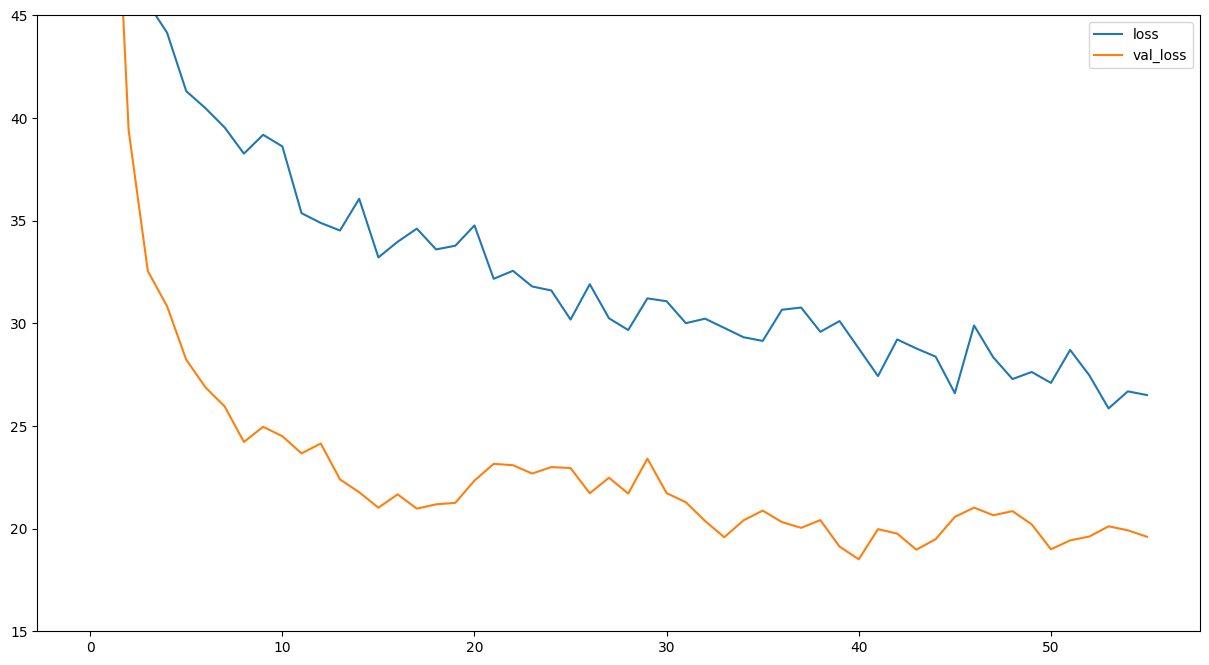

In [231]:
plt.figure(figsize=(15,8))
history_df = pd.DataFrame(history_ann.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
# plt.scatter(len(history_df) , mse_dnn, marker="o",color = "r")
# plt.xlim(-2,50)
plt.ylim(15,45)
plt.show()

In [139]:
plt.figure(figsize=(8,5))
history_df = pd.DataFrame(history_dnn.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
plt.scatter(len(history_df) , mse_dnn, marker="o",color = "r")
plt.xlim(400,900)
plt.ylim(5,15)

plt.show()

NameError: name 'history_dnn' is not defined

<Figure size 800x500 with 0 Axes>

### TEST Scores

In [ ]:
pred_dnn = ann_clf.predict(X_test_bm_sc)

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

mse_dnn = mean_squared_error(y_test , pred_dnn)
mape_dnn = mean_absolute_percentage_error(y_test , pred_dnn)
mae_dnn = mean_absolute_error(y_test , pred_dnn)

Scores_df_dnn = pd.DataFrame(index=["Validation","Test"],columns=["mse","mape","mae"])
Scores_df_dnn.loc["Validation",:] = [history_dnn.history["loss"][-1] , history_dnn.history["mape"][-1] , history_dnn.history["mae"][-1]]
Scores_df_dnn.loc["Test",:] = [mse_dnn , mape_dnn*100 , mae_dnn]
Scores_df_dnn.loc["Percentage_Difference",:] = (Scores_df_dnn.loc["Test"] - Scores_df_dnn.loc["Validation"])/Scores_df_dnn.loc["Test"]*100

Scores_df_dnn

,mse,mape,mae
Validation,6.659935,8.047577,2.005603
Test,9.859986,10.382125,2.282136
Percentage_Difference,32.454925,22.486229,12.117279


## 4) FFNN + CNN (Feed Forward Neural Net. + Convunutional Neural Network)

### Splitting CNN's data

In [ ]:
# # CNN SPLIT

# reduced_size = (28,28) # Images' sizes reduced due to deficiency of computing power

# X_train_image = []
# for idx in X_train.index:
#     current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
#     current_image = current_image.resize(reduced_size)
#     arr = np.array(current_image)
#     X_train_image.append(arr)

# X_train_image = np.array(X_train_image)

# X_test_image = []
# for idx in X_test.index:
#     current_image = PIL.Image.open(image_df.loc[idx,"full_paths"])
#     current_image = current_image.resize(reduced_size)
#     arr = np.array(current_image)
#     X_test_image.append(arr)

# X_test_image = np.array(X_test_image)

### Scaling

In [232]:
X_train_imgs = Data.train_imgs/255
X_test_imgs = Data.test_imgs/255

### Model Creation

In [239]:
Input_tb_ = keras.Input(shape=(X_train_bm_sc.shape[1],),name="TabularInput")
Hidden1_tb_ = keras.layers.Dense(32, activation=keras.activations.relu,name="TBHidden1")(Input_tb_)
Dropout1_tb_ = keras.layers.Dropout(0.3)(Hidden1_tb_)
Hidden2_tb_ = keras.layers.Dense(16, activation=keras.activations.relu,name="TBHidden2")(Dropout1_tb_)
Dropout2_tb_ = keras.layers.Dropout(0.3)(Hidden2_tb_)

Input_img_ = keras.Input(shape = X_train_imgs.shape[1:])
Conv1_img_ = keras.layers.Conv2D(16, kernel_size=(3,3), activation="relu")(Input_img_)
Pool1_img_ = keras.layers.MaxPool2D(pool_size=(2,2))(Conv1_img_)
Conv2_img_ = keras.layers.Conv2D(8, kernel_size=(3,3), activation="relu")(Pool1_img_)
Pool2_img_ = keras.layers.MaxPool2D(pool_size=(2,2))(Conv2_img_)
Flatten_img_ = keras.layers.Flatten()(Pool2_img_)
Hidden1_img_ = keras.layers.Dense(32, activation="swish")(Flatten_img_)
Dropout_img_ = keras.layers.Dropout(0.2)(Hidden1_img_)
Hidden2_img_ = keras.layers.Dense(16, activation="tanh")(Dropout_img_)

# # - 
# inputs = keras.Input(shape = X_train_image.shape[1:])
# conv1 = layers.Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
# pool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
# conv2 = layers.Conv2D(8, kernel_size=(3,3), activation="relu")(pool1)
# pool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
# flatten = layers.Flatten()(pool2)

# x = layers.Dense(64, activation="swish")(flatten)
# Dropout = tf.keras.layers.Dropout(0.1)(x)
# x = layers.Dense(64, activation="tanh")(Dropout)
# # - 


Concat_ = keras.layers.concatenate([Dropout2_tb_, Hidden2_img_])
Hidden3_ = keras.layers.Dense(32, activation=keras.activations.relu,name="LastHidden")(Concat_)

Outputs_ = keras.layers.Dense(1, activation="linear")(Hidden3_)

mdl = keras.Model(inputs = [Input_tb_, Input_img_], outputs = [Outputs_])

mdl.summary()

mdl.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.MeanSquaredError() , 
metrics=[keras.metrics.MeanAbsolutePercentageError()])

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss",patience=15)

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 26, 26, 16)   448         ['input_21[0][0]']               
                                                                                                  
 max_pooling2d_40 (MaxPooling2D  (None, 13, 13, 16)  0           ['conv2d_40[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 11, 11, 8)    1160        ['max_pooling2d_40[0][0]']

In [240]:
history_ann = mdl.fit([X_train_bm_sc, X_train_imgs], y_train_bm, epochs=200, validation_split=0.15,
verbose=2,callbacks=[early_stop],batch_size=16)

Epoch 1/200
99/99 - 4s - loss: 443.8622 - mean_absolute_percentage_error: 72.4291 - val_loss: 105.1411 - val_mean_absolute_percentage_error: 30.6859 - 4s/epoch - 35ms/step
Epoch 2/200
99/99 - 1s - loss: 57.0688 - mean_absolute_percentage_error: 22.9033 - val_loss: 41.4028 - val_mean_absolute_percentage_error: 16.1832 - 995ms/epoch - 10ms/step
Epoch 3/200
99/99 - 1s - loss: 38.3693 - mean_absolute_percentage_error: 19.1148 - val_loss: 28.8348 - val_mean_absolute_percentage_error: 14.8836 - 999ms/epoch - 10ms/step
Epoch 4/200
99/99 - 1s - loss: 28.3944 - mean_absolute_percentage_error: 16.5609 - val_loss: 22.0374 - val_mean_absolute_percentage_error: 14.0084 - 997ms/epoch - 10ms/step
Epoch 5/200
99/99 - 1s - loss: 24.2279 - mean_absolute_percentage_error: 15.4195 - val_loss: 19.4730 - val_mean_absolute_percentage_error: 13.7471 - 997ms/epoch - 10ms/step
Epoch 6/200
99/99 - 1s - loss: 21.0827 - mean_absolute_percentage_error: 14.6564 - val_loss: 18.4294 - val_mean_absolute_percentage_erro

In [ ]:
inputs = keras.Input(shape = X_train_image.shape[1:])
conv1 = layers.Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
pool1 = layers.MaxPool2D(pool_size=(2,2))(conv1)
conv2 = layers.Conv2D(8, kernel_size=(3,3), activation="relu")(pool1)
pool2 = layers.MaxPool2D(pool_size=(2,2))(conv2)
flatten = layers.Flatten()(pool2)

x = layers.Dense(64, activation="swish")(flatten)
Dropout = tf.keras.layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="tanh")(Dropout)

outputs = layers.Dense(1, activation="relu")(x)

mdl = keras.Model(inputs = inputs, outputs = outputs)

mdl.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                1286

In [ ]:
mdl.compile(optimizer="adam" , loss = "mse" , metrics=["mape","mae"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=25)

history_cnn = mdl.fit(X_train_image,y_train,epochs=10,validation_split=0.15,verbose=1,callbacks=[early_stop])

Epoch 1/10
48/48 [==============================] - 2s 27ms/step - loss: 409.8569 - mape: 70.7403 - mae: 19.3238 - val_loss: 242.1642 - val_mape: 54.2672 - val_mae: 14.8916
Epoch 2/10
48/48 [==============================] - 1s 17ms/step - loss: 208.8163 - mape: 48.6000 - mae: 13.5779 - val_loss: 159.8538 - val_mape: 42.5513 - val_mae: 11.8316
Epoch 3/10
48/48 [==============================] - 1s 16ms/step - loss: 139.4894 - mape: 37.9945 - mae: 10.7861 - val_loss: 105.3470 - val_mape: 32.9629 - val_mae: 9.3000
Epoch 4/10
48/48 [==============================] - 1s 16ms/step - loss: 93.3062 - mape: 29.8310 - mae: 8.5489 - val_loss: 69.4002 - val_mape: 25.3235 - val_mae: 7.2340
Epoch 5/10
48/48 [==============================] - 1s 16ms/step - loss: 63.7597 - mape: 24.0199 - mae: 6.8705 - val_loss: 47.3582 - val_mape: 20.4142 - val_mae: 5.8116
Epoch 6/10
48/48 [==============================] - 1s 17ms/step - loss: 45.6253 - mape: 20.1762 - mae: 5.6860 - val_loss: 34.3058 - val_mape: 1

### TEST Scores

In [ ]:
pred_cnn = mdl.predict(X_test_image)

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

mse_cnn = mean_squared_error(y_test , pred_cnn)
mape_cnn = mean_absolute_percentage_error(y_test , pred_cnn)
mae_cnn = mean_absolute_error(y_test , pred_cnn)

Scores_df_cnn = pd.DataFrame(index=["Validation","Test"],columns=["mse","mape","mae"])
Scores_df_cnn.loc["Validation",:] = [history_cnn.history["loss"][-1] , history_cnn.history["mape"][-1] , history_cnn.history["mae"][-1]]
Scores_df_cnn.loc["Test",:] = [mse_cnn , mape_cnn*100 , mae_cnn]
Scores_df_cnn.loc["Percentage_Difference",:] = (Scores_df_cnn.loc["Test"] - Scores_df_cnn.loc["Validation"])/Scores_df_cnn.loc["Test"]*100

Scores_df_cnn

,mse,mape,mae
Validation,25.102423,15.859835,4.038238
Test,27.318265,17.309494,4.183724
Percentage_Difference,8.11121,8.374938,3.477438


### Plot

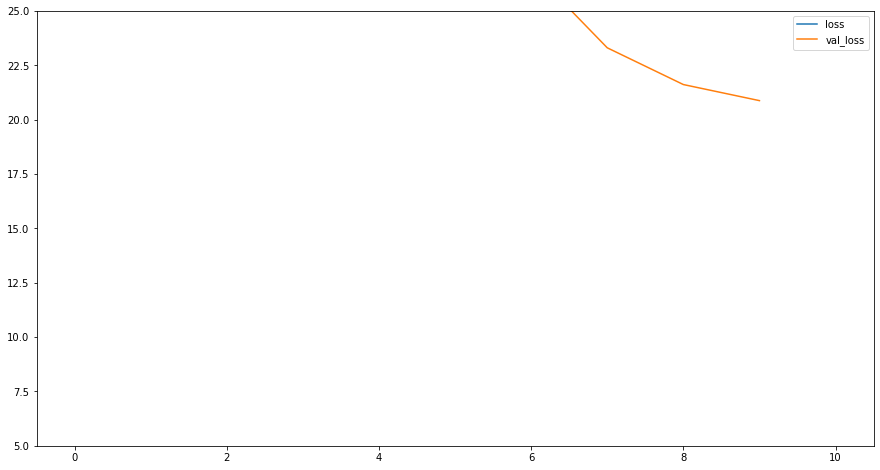

In [ ]:
plt.figure(figsize=(15,8))
history_df = pd.DataFrame(history_cnn.history)
sns.lineplot(data=history_df[["loss","val_loss"]],dashes=False)
plt.scatter(len(history_df) , mse_cnn, marker="o",color = "r")
# plt.xlim(-2,50)
plt.ylim(5,25)

plt.show()

## Downloading NLP's resuls

In [ ]:
lstm_results_train = pd.read_csv("lstm_results_train.csv",index_col=0)
lstm_results_test = pd.read_csv("lstm_results_test.csv",index_col=0)

In [ ]:
lstm_results_train.head()

,target,lstm_result_tr
1681,21.500000,21.713280
1195,29.475468,30.310078
985,16.400000,19.128582
862,20.516292,21.284727
1017,31.485159,29.244856


In [ ]:
lstm_results_test.head()

,target,lstm_result
1094,27.600000,26.112827
188,26.600000,26.355648
1800,32.335674,25.619324
707,23.000000,25.130505
679,28.805571,27.756561


### TEST Scores

In [ ]:
mse_nlp = mean_squared_error(y_test , lstm_results_test["lstm_result"])
mape_nlp = mean_absolute_percentage_error(y_test , lstm_results_test["lstm_result"])
mae_nlp = mean_absolute_error(y_test , lstm_results_test["lstm_result"])

Scores_df_nlp = pd.DataFrame(index=["Test"],columns=["mse","mape","mae"])
Scores_df_nlp.loc["Test",:] = [mse_nlp , mape_nlp*100 , mae_nlp]

Scores_df_nlp

,mse,mape,mae
Test,32.178437,18.770643,4.553034


In [ ]:
mse_nlp = mean_squared_error(y_train , lstm_results_train["lstm_result_tr"])
mse_nlp

# **OVERFIT IN NLP**

4.809008975247715

In [ ]:
Scores_df_nlp

,mse,mape,mae
Test,32.178437,18.770643,4.553034


## Combining **DNN & CNN & NLP**

In [ ]:
dnn_results = model.predict(X_test_scaled)
cnn_results = mdl.predict(X_test_image)
nlp_results = lstm_results_test["lstm_result"].values.reshape(-1,1)

dnn_weight = 0.6
cnn_weight = 0.2
nlp_weight = 0.2

final_results = (dnn_results*dnn_weight) + (cnn_results*cnn_weight) + (nlp_results*nlp_weight)

In [ ]:
dnn_results.shape , cnn_results.shape , nlp_results.shape

((593, 1), (593, 1), (593, 1))

## HYBRID MODEL RESULTS

In [ ]:
mse_hybrid = mean_squared_error(y_test , final_results)
mape_hybrid = mean_absolute_percentage_error(y_test , final_results)
mae_hybrid = mean_absolute_error(y_test , final_results)

Scores_df_hybrid = pd.DataFrame(index=["Test"],columns=["mse","mape","mae"])
Scores_df_hybrid.loc["Test",:] = [mse_hybrid , mape_hybrid*100 , mae_hybrid]

Scores_df_hybrid

,mse,mape,mae
Test,12.771636,11.839032,2.678785


In [ ]:
dnn_arr = Scores_df_dnn.loc["Test",:].values.reshape(1,3)
cnn_arr = Scores_df_cnn.loc["Test",:].values.reshape(1,3)
nlp_arr = Scores_df_nlp.values
hybrid_arr = Scores_df_hybrid.values
full_arr = np.concatenate((dnn_arr,cnn_arr,nlp_arr,hybrid_arr))

In [ ]:
ALL_MODELS_RESULTS = pd.DataFrame(full_arr , index = ["DNN","CNN","NLP","HYBRID"],columns=["mse","mape","mae"])
ALL_MODELS_RESULTS

,mse,mape,mae
DNN,9.859986,10.382125,2.282136
CNN,27.318265,17.309494,4.183724
NLP,32.178437,18.770643,4.553034
HYBRID,12.771636,11.839032,2.678785
